In [208]:
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import os
import numpy as np
import seaborn as sns

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [209]:
CLF_METRICS = ["kappa"] #, "precision", "recall", "f1-score"]
CLF_MODELS = ["RandomForestClassifier"] #, "DecisionTreeClassifier", "LogisticRegression", "SVC"]

REG_METRICS = ["r2"] # , "mse", "std"]
REG_MODELS = ["RandomForestRegressor"] #, "DecisionTreeRegressor"]

DATASETS = [file for file in os.listdir("../../datasets/synthetic/") if "csv" in file]
REG_DATASETS = ["gradual_friedman.csv"]
CLF_DATASETS = list(set(DATASETS).difference(set(REG_DATASETS)))

In [210]:
def get_concept(original_idx: pd.Series, dataset: str, concept_type="last"):
    """Read the original dataframe to recover the context

    Args:
        original_idx (pd.Series): maps the metabase indexes to the original base indexes (before windowing)
        dataset (str): dataset name to be loaded
        concept_type (str, optional): how to set the window concept, it can be:
            - "last": The last concept of the batch
            - "most_frequent": The most frequent concept of the batch
    """
    filename_concept = f'../../datasets/synthetic/{dataset}'
    df_concept = pd.read_csv(filename_concept)['concept']

    concepts = []
    for idx in original_idx:
        bounds = [int(bound) for bound in idx.split(':')]
        concept_batch = df_concept[bounds[0]:bounds[1]]
        
        if concept_type == "last":
            concepts.append(concept_batch.values[-1])
        else:
            most_frequent_concept = concept_batch.value_counts().idxmax()
            concepts.append(most_frequent_concept)
    return concepts

def load_data(dataset, model, concept_type="last"):
    filename_mtl = f'../metabases/basemodel: {model} - dataset: {dataset} - with_drift_metrics.csv'
    results = pd.read_csv(filename_mtl)
    concept = get_concept(results['original_idx'], dataset, concept_type)
    results['concept'] = concept
    return results

In [211]:
def remove_unused_cols(df: pd.DataFrame) -> pd.DataFrame:
    metrics = CLF_METRICS if "kappa" in df.columns else REG_METRICS
    cols_to_keep = [
        "concept",  # concept
        *metrics,  # target cols
        *[f"last_{col}" for col in metrics],  # baseline cols
        *[col for col in df.columns if "drift" in col],  # drift metrics cols
        *[col for col in df.columns if "predicted" in col],  # mtl cols
    ]
    return df[cols_to_keep]

def gen_drift_alerts(dataset: str, model: str, metric: str) -> pd.DataFrame:
    df = load_data(dataset, model)
    offline_df = df[df["data_type"] == "offline"]
    online_df = df[df["data_type"] == "online"]
    online_df = remove_unused_cols(online_df)

    expected_mean, expected_std = offline_df[metric].mean(), offline_df[metric].std()

    for sensitivity in [0.5, 1, 1.5, 2]:
        threshold = expected_mean - expected_std * sensitivity
        online_df[f"mtl_alert_{metric}_s={sensitivity}"] = (online_df[f"predicted_{metric}"] <= threshold).astype(int)
        # online_df[f"baseline_alert_{metric}_s={sensitivity}"] = (online_df[f"last_{metric}"] <= threshold).astype(int)
    online_df["target_alert"] = (online_df["concept"] > 0).astype(int)
    online_df["real_alert"] = (online_df[metric] <= threshold).astype(int)
    return online_df

In [212]:
results = {}

for dataset in DATASETS:
    try:
        metric = "kappa" if dataset in CLF_DATASETS else "r2"
        model = "RandomForestClassifier" if dataset in CLF_DATASETS else "RandomForestRegressor"
        results[dataset] = gen_drift_alerts(dataset, model, metric)
    except:
        print(dataset)

# Drift label comparison

In [222]:
def get_perf_metrics(df: pd.DataFrame, dataset: str, target_col="target_alert") -> list:
    alert_cols = [c for c in df.columns if ("_drift_" in c or "_alert" in c)]
    results = []

    for col in alert_cols:
        sensitivity = col.split("s=")[1] if "s=" in col else None
        alert_type = "drift_metrics" if "_drift_" in col else col.split("_")[0]

        # Generate confusion matrix
        cm = confusion_matrix(df[target_col], df[col], labels = [0, 1]).ravel()
        results.append({
            'dataset': dataset.replace('.csv', ''),
            'alert_col': col,
            'type': alert_type,
            'sensitivity': sensitivity,
            'True Negatives': cm[0], 
            'False Positives': cm[1], 
            'False Negatives': cm[2], 
            'True Positives': cm[3],
            'accuracy': accuracy_score(df[target_col], df[col]),
            **classification_report(df[target_col], df[col], labels = [0, 1], output_dict=True)['1']
        })
    return results

final_performances = []
for dataset, df in results.items():
    df = results[dataset]
    final_performances = [*final_performances, *get_perf_metrics(df, dataset)]
final_performances_df = pd.DataFrame(final_performances)

In [214]:
final_performances_df.head()

,dataset,alert_col,type,sensitivity,True Negatives,False Positives,False Negatives,True Positives,accuracy,precision,recall,f1-score,support
0,no_drift_agrawal_unbalanced_increasing_noise,u_detect_drift_flag,drift_metrics,None,326,64,0,0,0.835897,0.0,0.0,0.0,0.0
1,no_drift_agrawal_unbalanced_increasing_noise,omv_pth_drift_flag,drift_metrics,None,390,0,0,0,1.000000,0.0,0.0,0.0,0.0
2,no_drift_agrawal_unbalanced_increasing_noise,psi_drift_flag,drift_metrics,None,0,390,0,0,0.000000,0.0,0.0,0.0,0.0
3,no_drift_agrawal_unbalanced_increasing_noise,sqsi_drift_flag,drift_metrics,None,361,29,0,0,0.925641,0.0,0.0,0.0,0.0
4,no_drift_agrawal_unbalanced_increasing_noise,dc_drift_flag,drift_metrics,None,390,0,0,0,1.000000,0.0,0.0,0.0,0.0


In [215]:
def plot_heatmap(df: pd.DataFrame, metric='recall'):
    # Pivot the DataFrame to create a matrix of values
    pivot_df = df.pivot(index='dataset', columns='alert_col', values=metric)

    # Create a heat map using seaborn
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_df, annot=True, cmap='viridis', fmt='.2f')

    # Set labels and title
    plt.xlabel('Alert Column')
    plt.ylabel('Dataset')
    plt.title(f'{metric} heatmap')

    # Show the plot
    plt.show()

df = final_performances_df[final_performances_df["dataset"] != "gradual_friedman"]
df = df[df["alert_col"] != "target_alert"].sort_values(by="recall", ascending=False)

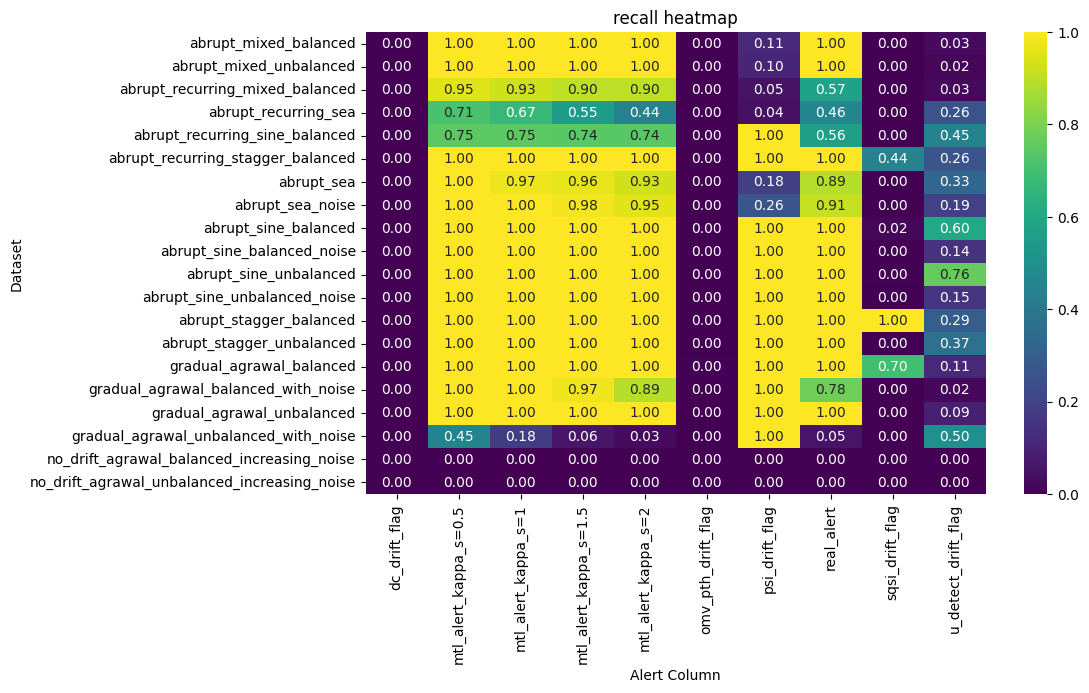

In [216]:
plot_heatmap(df, 'recall')

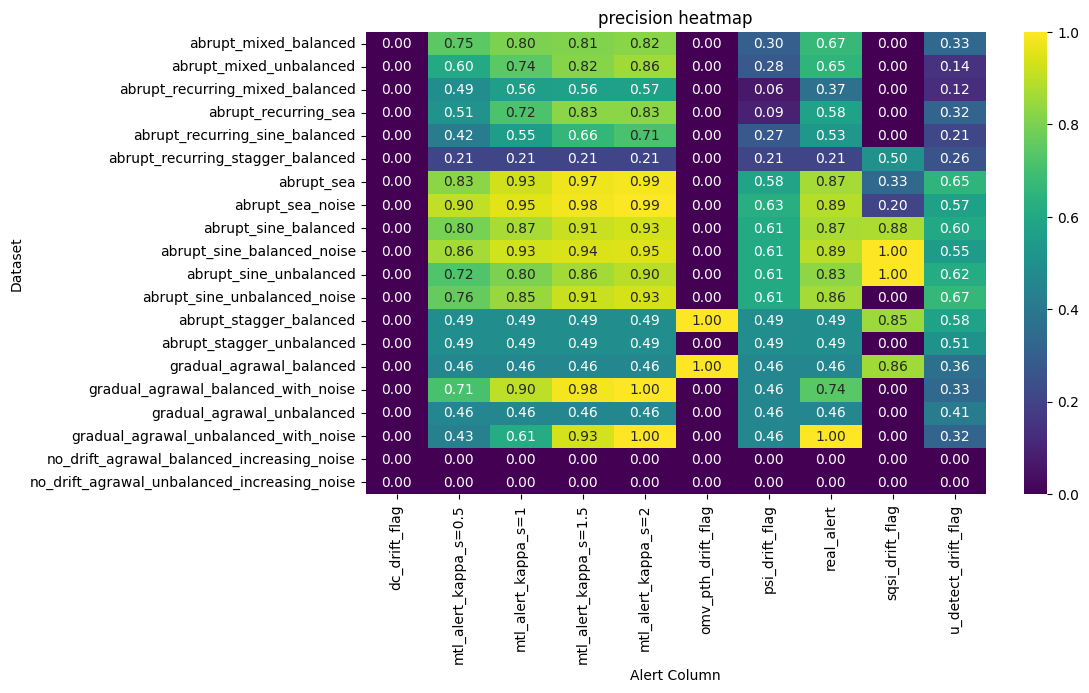

In [217]:
plot_heatmap(df, 'precision')

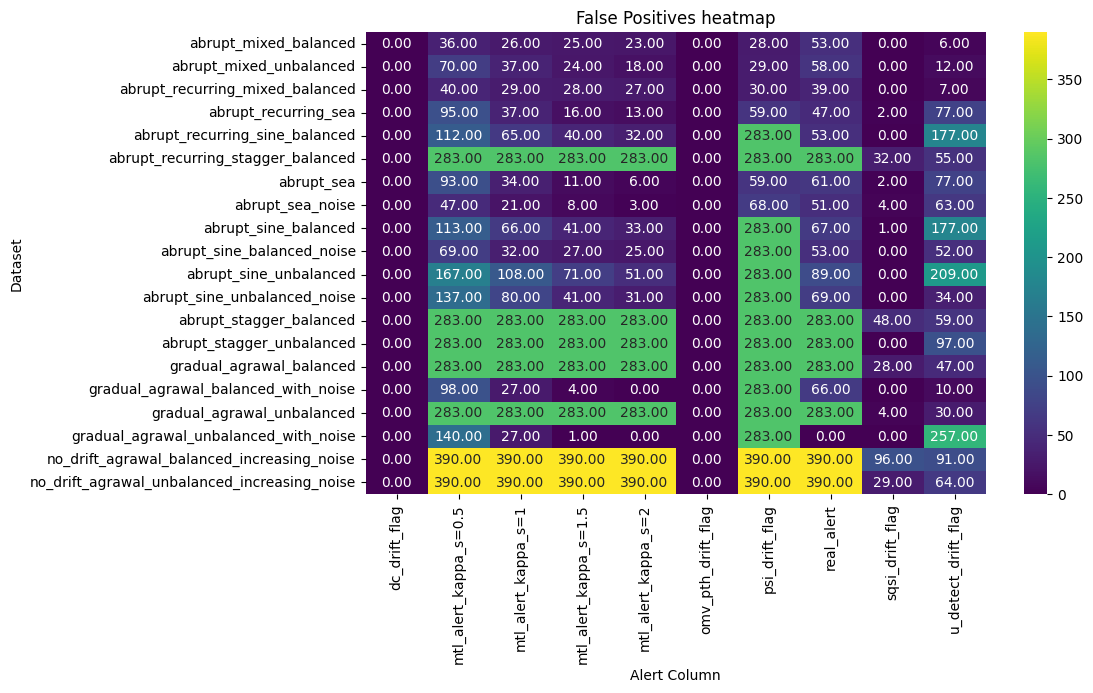

In [218]:
plot_heatmap(df, 'False Positives')

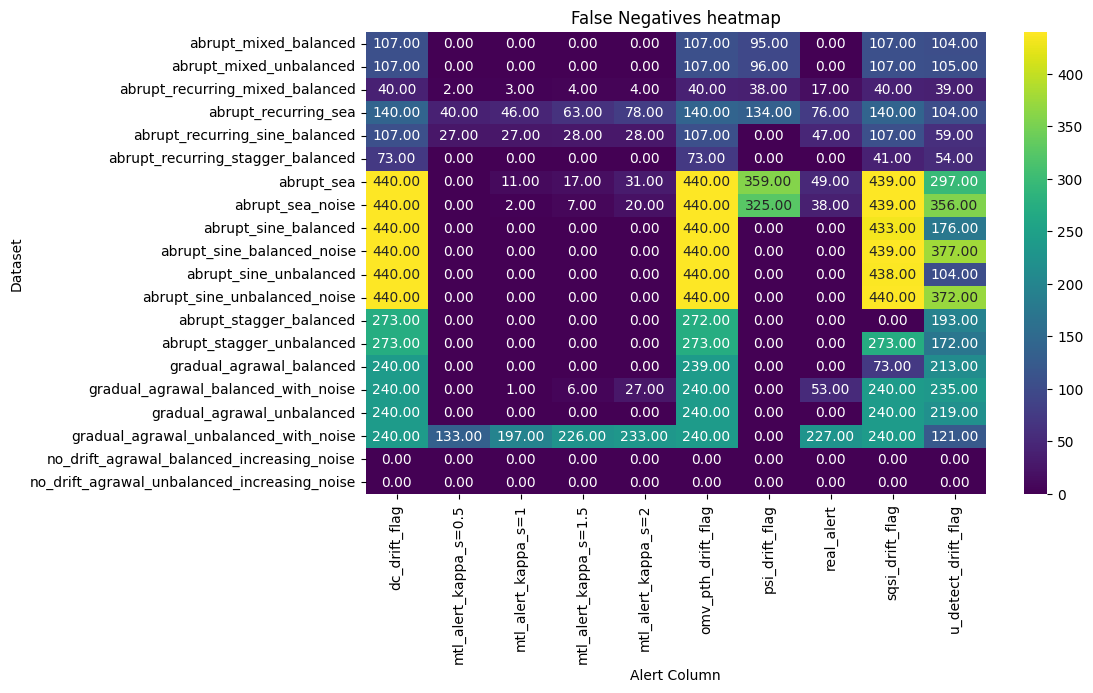

In [219]:
plot_heatmap(df, 'False Negatives')

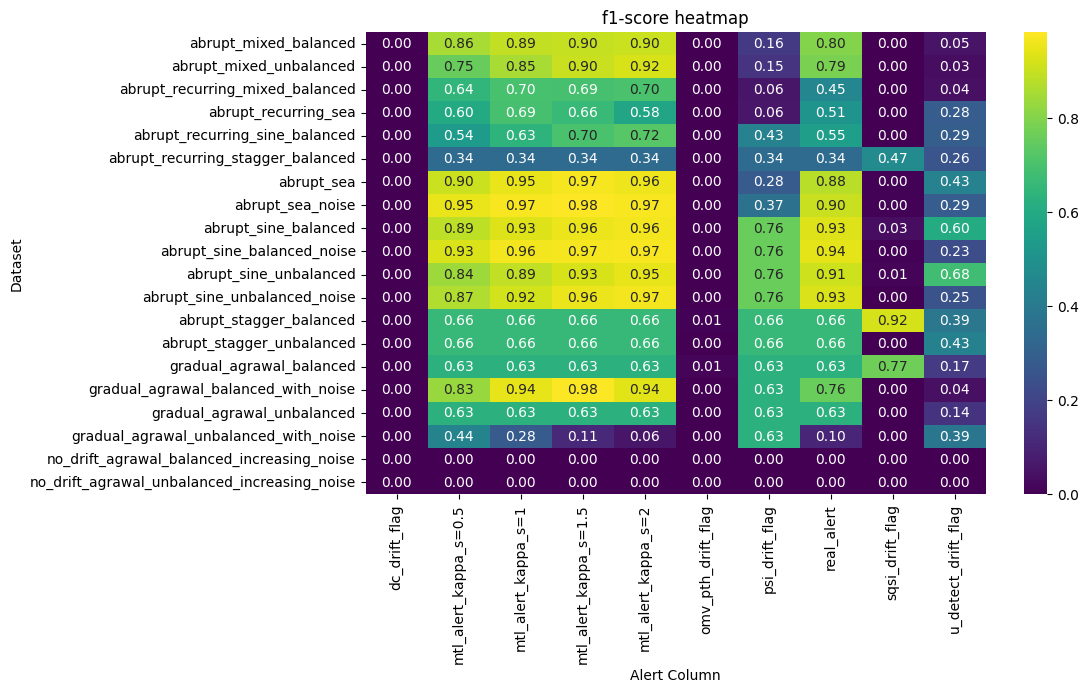

In [220]:
plot_heatmap(df, 'f1-score')

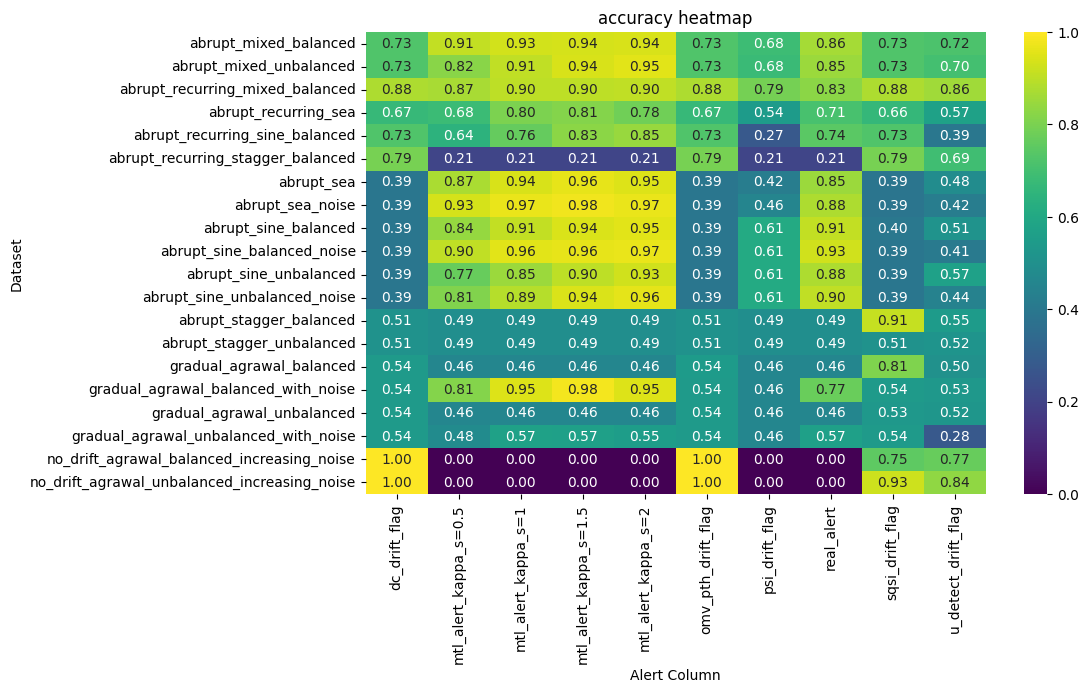

In [221]:
plot_heatmap(df, 'accuracy')

# Real performance drop comparison

In [227]:
real_perf = []
for dataset, df in results.items():
    df = results[dataset]
    real_perf = [*real_perf, *get_perf_metrics(df, dataset, "real_alert")]
real_perf_df = pd.DataFrame(real_perf)

In [228]:
df = real_perf_df[real_perf_df["dataset"] != "gradual_friedman"]
df = df[df["alert_col"] != "target_alert"].sort_values(by="recall", ascending=False)
df = df[df["alert_col"] != "real_alert"].sort_values(by="recall", ascending=False)

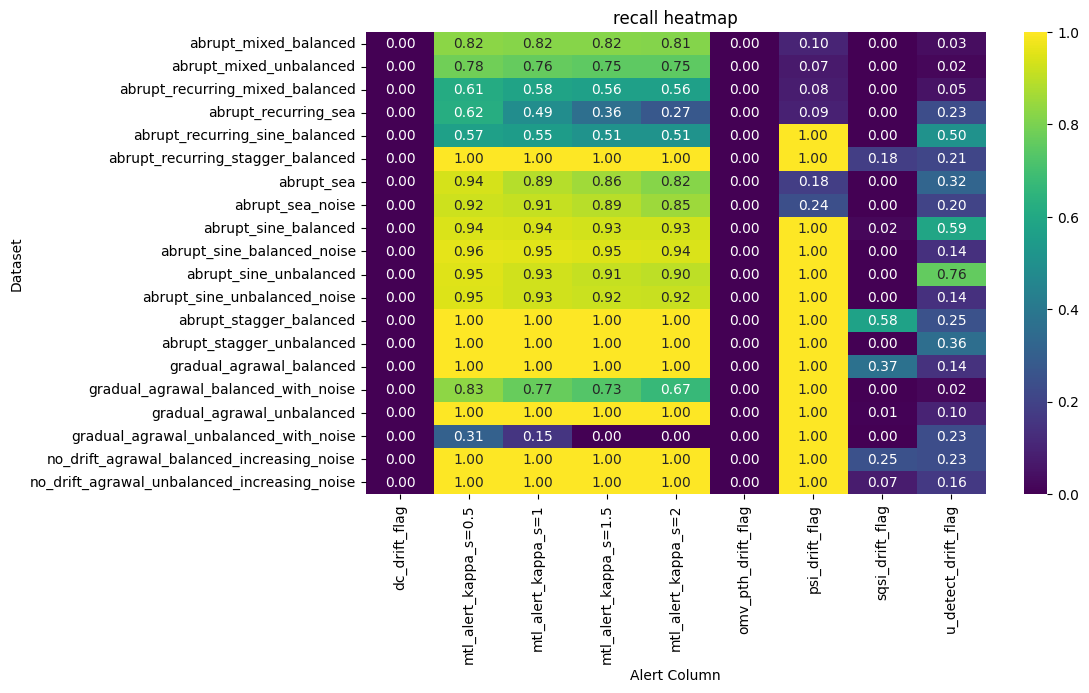

In [229]:
plot_heatmap(df, 'recall')

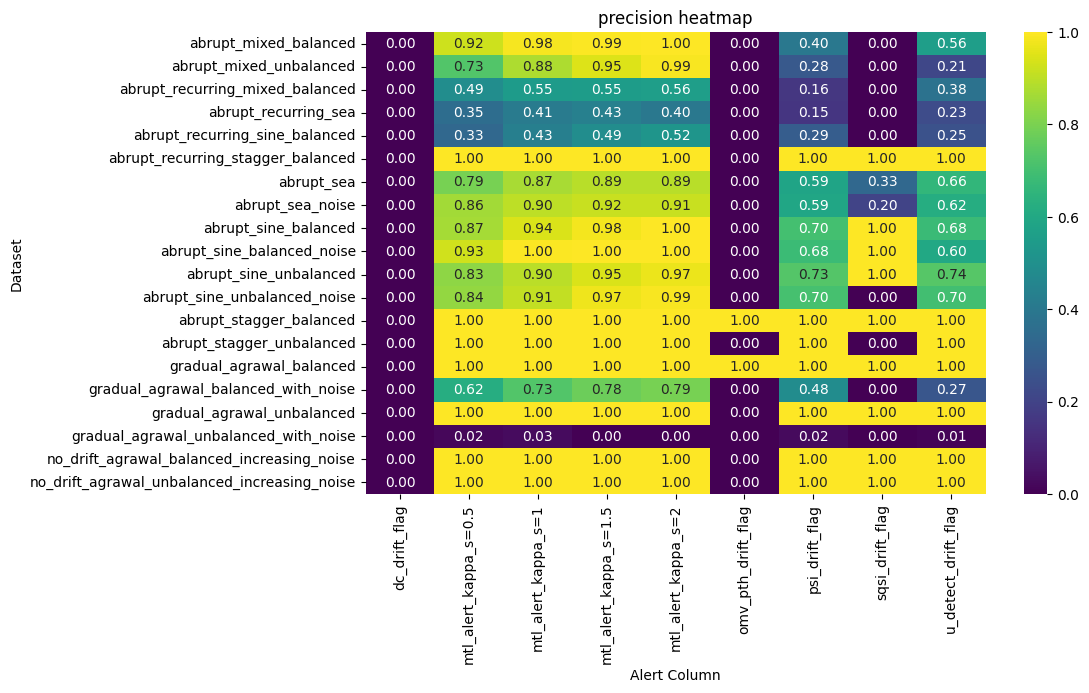

In [230]:
plot_heatmap(df, 'precision')

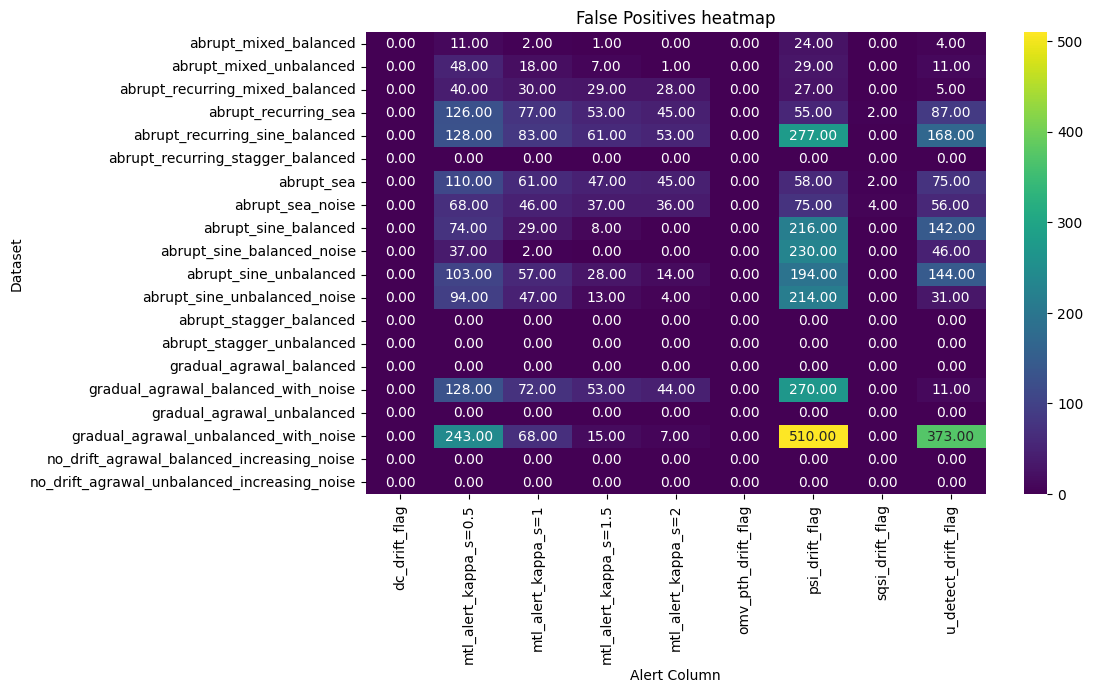

In [231]:
plot_heatmap(df, 'False Positives')

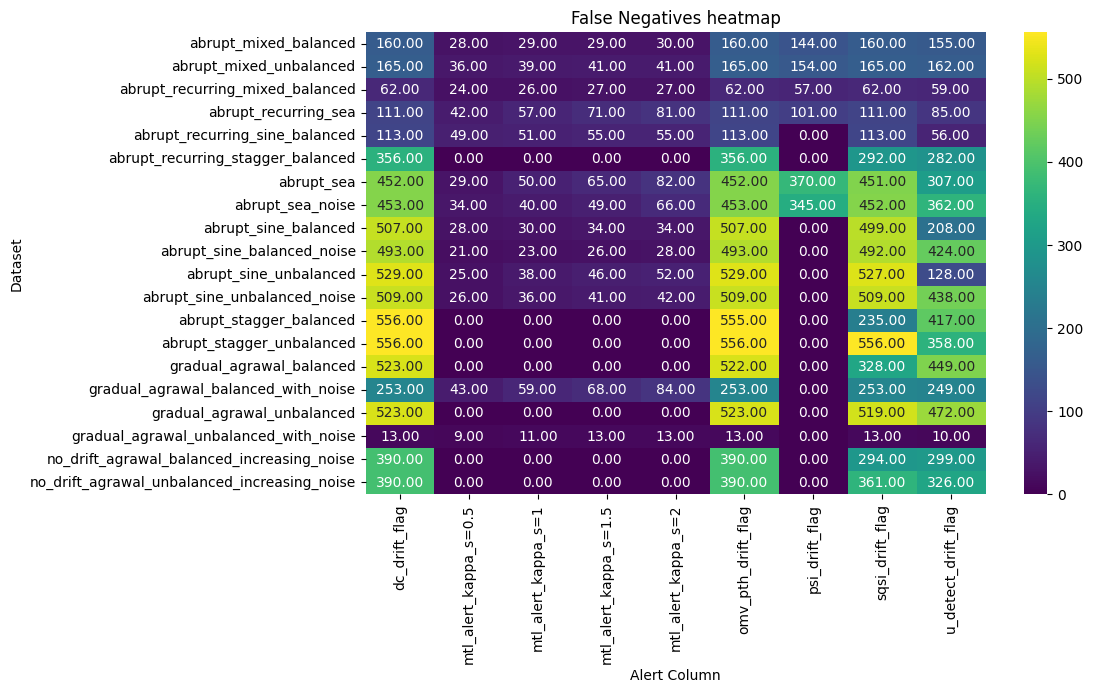

In [232]:
plot_heatmap(df, 'False Negatives')

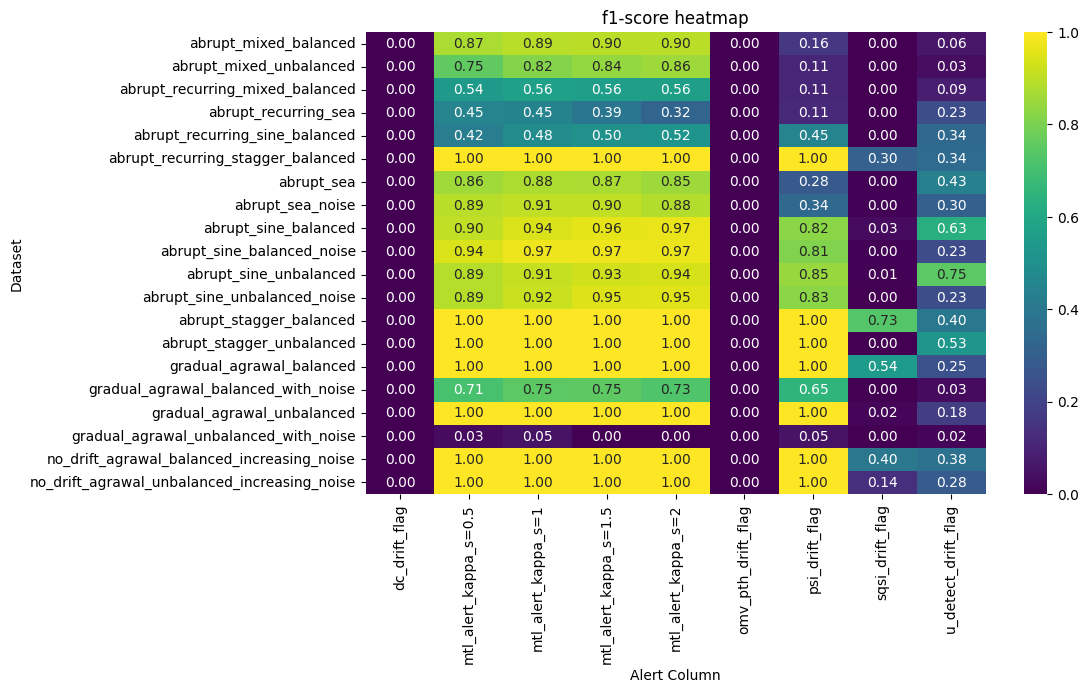

In [233]:
plot_heatmap(df, 'f1-score')

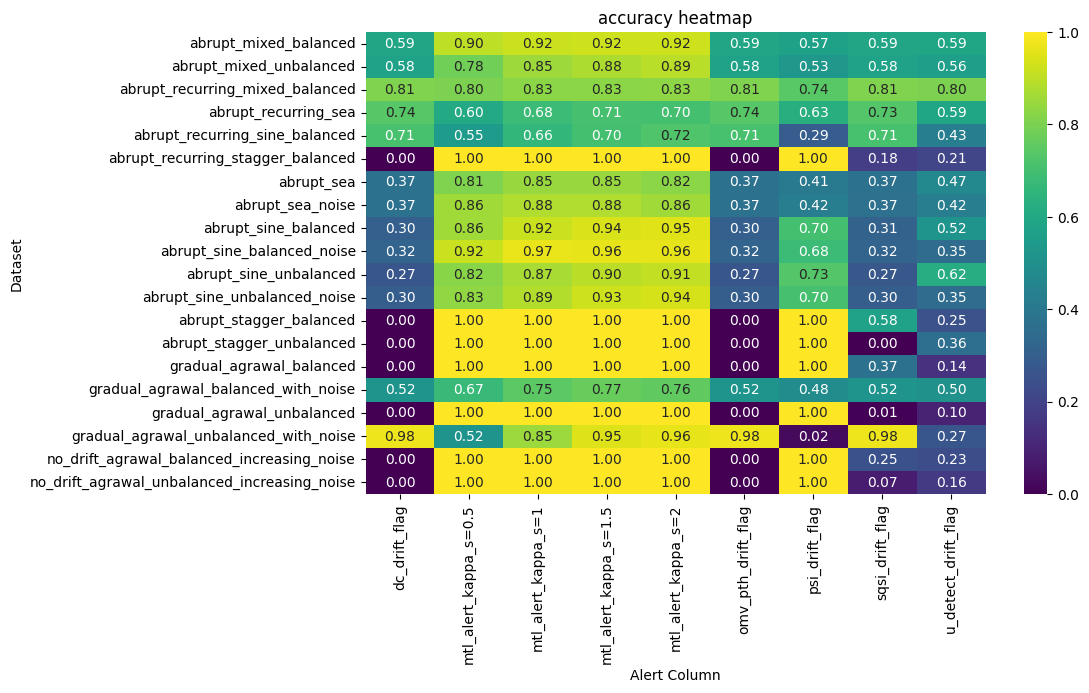

In [234]:
plot_heatmap(df, 'accuracy')